In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

def ResNet_IdentityBlock(x, filters, l2_reg=1e-4):
    x_skip = x
    f1, f2 = filters

    x = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=f1, kernel_size=(3, 3), strides=(1, 1), padding='same',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=f2, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def ResNet_ConvBlock(x, s, filters, l2_reg=1e-4):
    x_skip = x
    f1, f2 = filters

    x = Conv2D(filters=f1, kernel_size=(1, 1), strides=(s, s), padding='valid',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=f1, kernel_size=(3, 3), strides=(1, 1), padding='same',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=f2, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    x_skip = Conv2D(filters=f2, kernel_size=(1, 1), strides=(s, s), padding='valid',
                    kernel_regularizer=l2(l2_reg))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

from tensorflow.keras.regularizers import l2

def ResNet50(input_size=(224, 224, 3), num_classes=8, dropout_rate=0.2, l2_reg=1e-4):
    input = Input(input_size)
    x = ZeroPadding2D(padding=(3, 3))(input)

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D((3, 3), strides=(2, 2))(x)

    # Add Conv and Identity Blocks with L2 regularization
    x = ResNet_ConvBlock(x, s=1, filters=(64, 256), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(64, 256), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(64, 256), l2_reg=l2_reg)

    x = ResNet_ConvBlock(x, s=2, filters=(128, 512), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(128, 512), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(128, 512), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(128, 512), l2_reg=l2_reg)

    x = ResNet_ConvBlock(x, s=2, filters=(256, 1024), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(256, 1024), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(256, 1024), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(256, 1024), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(256, 1024), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(256, 1024), l2_reg=l2_reg)

    x = ResNet_ConvBlock(x, s=2, filters=(512, 2048), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(512, 2048), l2_reg=l2_reg)
    x = ResNet_IdentityBlock(x, filters=(512, 2048), l2_reg=l2_reg)

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)  # Include dropout
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=input, outputs=x)
    adam = Adam(learning_rate=1e-4)
    model.compile(optimizer=adam, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

    return model


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

def load_and_preprocess_images(dataset_dir, img_size):
    X = []
    y = []
    class_labels = []
    
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            class_labels.append(class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=img_size)
                    img_array = img_to_array(img)
                    img_array = resnet_preprocess(img_array)  # Apply ResNet preprocessing
                    X.append(img_array)
                    y.append(class_name)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    
    X = np.array(X, dtype="float32")
    y = np.array(y)
    
    # Encode class labels
    class_encoder = LabelEncoder()
    y = class_encoder.fit_transform(y)
    
    return X, y, class_encoder


In [3]:
dataset_dir = r"data"
img_size = (224, 224)

X, y, class_encoder = load_and_preprocess_images(dataset_dir, img_size)

In [4]:
from sklearn.model_selection import train_test_split
# Split into training and remaining (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test= train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [5]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))  # Dynamically determine the number of classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [6]:
model = ResNet50(input_size=(224, 224, 3), num_classes=num_classes, dropout_rate=0.2)

In [7]:
# Train the model without EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Set a specific number of epochs
    verbose=1,
    batch_size=16
)

Epoch 1/10
137/137 [==============================] - 467s 3s/step - loss: 4.7662 - categorical_accuracy: 0.3044 - val_loss: 4.9809 - val_categorical_accuracy: 0.1221
Epoch 2/10
137/137 [==============================] - 457s 3s/step - loss: 4.0923 - categorical_accuracy: 0.4535 - val_loss: 5.3991 - val_categorical_accuracy: 0.1970
Epoch 3/10
137/137 [==============================] - 453s 3s/step - loss: 3.5750 - categorical_accuracy: 0.5502 - val_loss: 3.3481 - val_categorical_accuracy: 0.6296
Epoch 4/10
137/137 [==============================] - 436s 3s/step - loss: 3.2622 - categorical_accuracy: 0.6199 - val_loss: 3.6038 - val_categorical_accuracy: 0.6060
Epoch 5/10
137/137 [==============================] - 439s 3s/step - loss: 3.0786 - categorical_accuracy: 0.6538 - val_loss: 3.7829 - val_categorical_accuracy: 0.6017
Epoch 6/10
137/137 [==============================] - 459s 3s/step - loss: 3.0780 - categorical_accuracy: 0.6667 - val_loss: 3.3976 - val_categorical_accuracy: 0.646

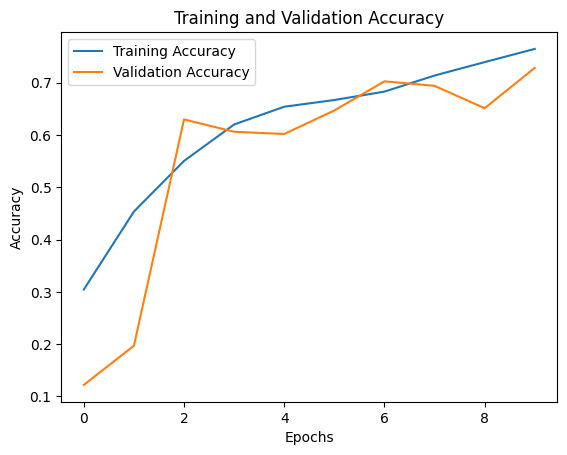

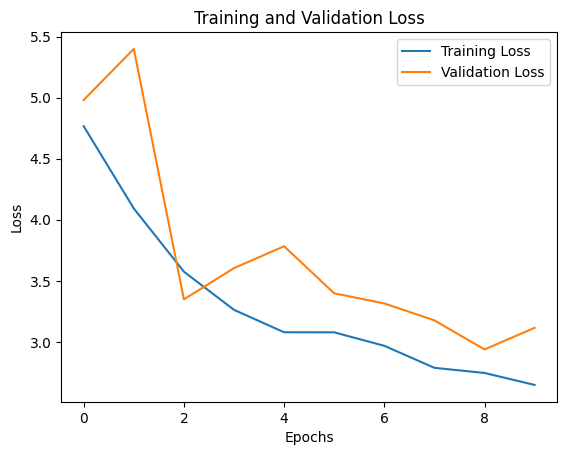

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Test Loss: 2.872587203979492
Test Accuracy: 0.745726466178894


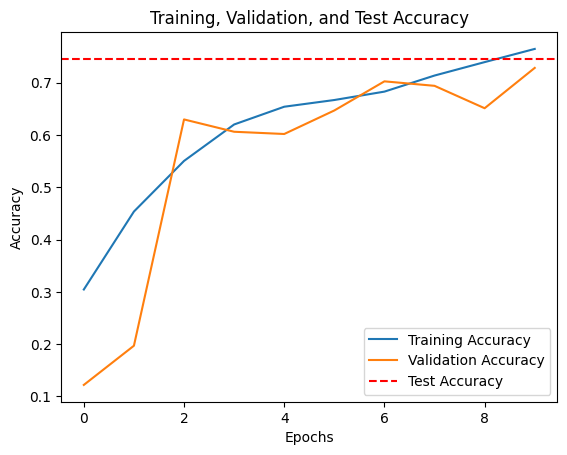

In [9]:
test_loss, test_accuracy = model.evaluate(X_test,y_test, verbose=0)

# Print test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training, validation, and test accuracy
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


In [10]:
# Assuming you have the history object from model.fit()
train_accuracy = history.history['categorical_accuracy'][-1]  # Last epoch training accuracy
val_accuracy = history.history['val_categorical_accuracy'][-1]  # Last epoch validation accuracy

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")


Training Accuracy: 0.7643283009529114
Validation Accuracy: 0.7280513644218445


15/15 [==============================] - 18s 1s/step


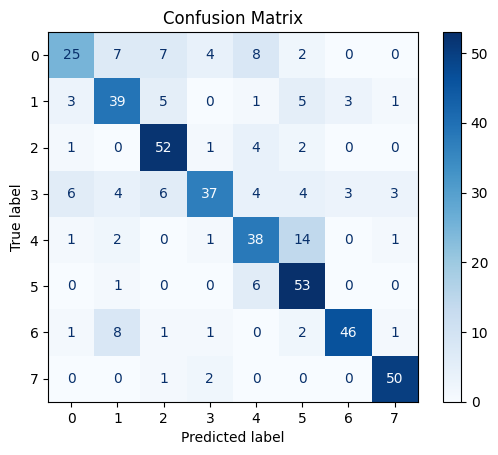

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.47      0.56        53
           1       0.64      0.68      0.66        57
           2       0.72      0.87      0.79        60
           3       0.80      0.55      0.65        67
           4       0.62      0.67      0.64        57
           5       0.65      0.88      0.75        60
           6       0.88      0.77      0.82        60
           7       0.89      0.94      0.92        53

    accuracy                           0.73       467
   macro avg       0.74      0.73      0.72       467
weighted avg       0.74      0.73      0.72       467



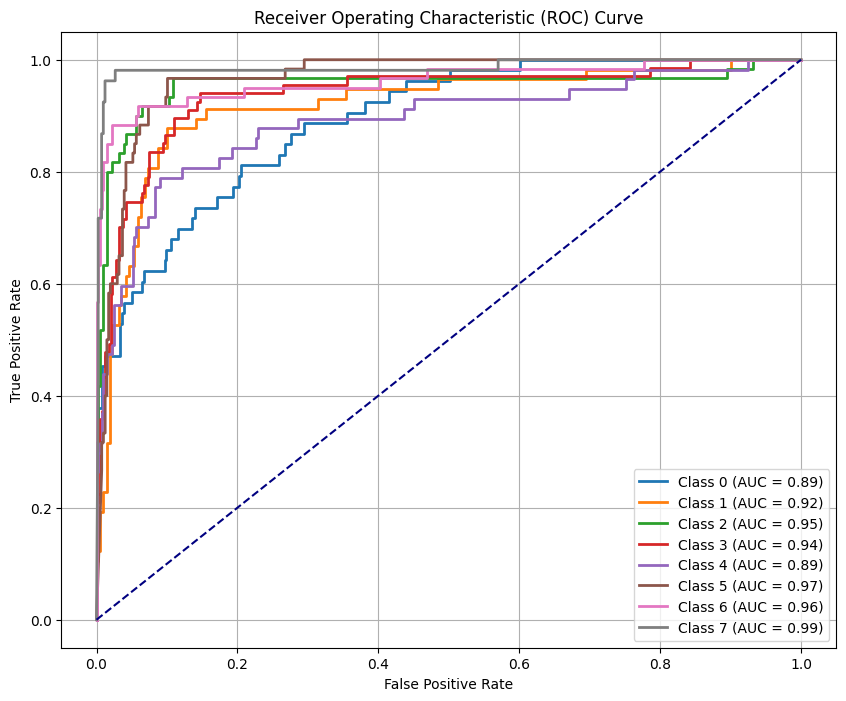

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

# 1. Get Predictions
y_pred_prob = model.predict(X_val)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted classes (for multi-class)

# If y_val is one-hot encoded, convert to class indices
if y_val.ndim > 1:
    y_val_classes = np.argmax(y_val, axis=1)
else:
    y_val_classes = y_val

# 2. Confusion Matrix
cm = confusion_matrix(y_val_classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred))

# 4. ROC Curve and AUC (for multi-class, compute per class)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(np.unique(y_val_classes))):  # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_prob[:, i]) if y_val.ndim > 1 else roc_curve((y_val_classes == i).astype(int), y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(roc_auc)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
